# Classification Metrics

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**

In [ ]:
# DO NOT DOWNLOAD DATASET FROM GITHUB. USE THE DS 32 KAGGLE COMPETITION LINK INSTEAD.
# %%capture
# import sys

# # If you're on Colab:
# if 'google.colab' in sys.modules:
#     DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
#     !pip install category_encoders==2.*

# # If you're working locally:
# else:
#     DATA_PATH = '../data/'

In [ ]:
!pip install category_encoders==2.*

     |████████████████████████████████| 80 kB 3.5 MB/s 


In [ ]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#change your working directory
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
# Download your Kaggle Dataset, if you haven't already done so. 
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
# !kaggle competitions download -c ds32-water-pump-challenge 

In [ ]:
# Unzip your Kaggle dataset, if you haven't already done so.
# !unzip \*.zip  && rm *.zip

In [ ]:
# List all files in Kaaggle folder.
!ls

kaggle.json	       test_features.csv   train_labels.csv
sample_submission.csv  train_features.csv


# I. Wrangle Data

In [ ]:
def wrangle(fm_path, tv_path=None):
  if tv_path:
    df = pd.merge(pd.read_csv(fm_path, 
                              na_values=[0, -2.000000e-08],
                              parse_dates=['date_recorded']),
                  pd.read_csv(tv_path)).set_index('id')
    
    # CREATE A NEW TARGET COLUMN
    df['needs_repair'] = np.where(df['status_group'] == 'functional', 0, 1)
    df.drop(columns='status_group', inplace=True)
  
  else:
    df = pd.read_csv(fm_path, 
                     na_values=[0, -2.000000e-08],
                     parse_dates=['date_recorded'],
                     index_col='id')
  

  # Drop constant columns
  df.drop(columns=['recorded_by'], inplace=True)

  # Create age feature
  df['pump_age'] = df['date_recorded'].dt.year - df['construction_year']
  df.drop(columns='date_recorded', inplace=True)

  # Drop HCCCs
  cutoff = 100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)

  # Drop duplicate columns
  dupe_cols = [col for col in df.head(100).T.duplicated().index
               if df.head(100).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)  

  # if 'status_group' in df:
  #   df['needs_repair'] = np.where(df['status_group'] == 'functional', 0, 1)           

  return df

df = wrangle(fm_path='train_features.csv',
             tv_path='train_labels.csv')

X_test = wrangle(fm_path='test_features.csv')

## EDA

- Transform target to a **binary classification** problem

In [ ]:
df

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,NaN,Internal,Manyara,21,1.0,160.0,True,Water Board,True,1998.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,15.0
510.0,NaN,NaN,35.510074,-5.724555,NaN,Internal,Dodoma,1,6.0,NaN,True,VWC,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,NaN
14146.0,NaN,NaN,32.499866,-9.081222,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,True,VWC,False,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional,NaN
47410.0,NaN,NaN,34.060484,-8.830208,NaN,Rufiji,Mbeya,12,7.0,NaN,True,VWC,True,NaN,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional,NaN
1288.0,300.0,1023.0,37.032690,-6.040787,NaN,Wami / Ruvu,Morogoro,5,1.0,120.0,True,VWC,True,1997.0,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other,non functional,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68525.0,1000.0,327.0,36.367112,-8.774761,NaN,Rufiji,Morogoro,5,4.0,255.0,True,Water Board,True,1995.0,gravity,gravity,gravity,wug,user-group,pay monthly,monthly,soft,good,enough,river,river/lake,surface,communal standpipe,communal standpipe,functional,16.0
11980.0,1000.0,1743.0,34.531524,-9.769604,NaN,Lake Nyasa,Iringa,11,5.0,35.0,True,VWC,False,1988.0,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,seasonal,spring,spring,groundwater,communal standpipe,communal standpipe,functional,23.0
35778.0,NaN,-13.0,38.974416,-5.420823,NaN,Pangani,Tanga,4,5.0,1000.0,False,Private operator,False,2005.0,other,other,other,private operator,commercial,never pay,never pay,soft,good,insufficient,shallow well,shallow well,groundwater,other,other,non functional,6.0


In [ ]:
df['status_group'].value_counts()

functional                 25802
non functional             18251
functional needs repair     3466
Name: status_group, dtype: int64

In [ ]:
df['status_group'].head(20)

id
454.0                   functional
510.0                   functional
14146.0             non functional
47410.0             non functional
1288.0              non functional
13095.0                 functional
558.0                   functional
35626.0                 functional
8696.0              non functional
48650.0                 functional
61055.0             non functional
27298.0                 functional
52899.0             non functional
61616.0             non functional
54295.0             non functional
18191.0    functional needs repair
22057.0                 functional
39797.0             non functional
20856.0                 functional
59340.0                 functional
Name: status_group, dtype: object

In [ ]:
# df['needs_repair'] = np.where(df['status_group'] == 'functional', 0, 1)[:20]

array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0])

In [ ]:
# def my_func(value):
#   if ( value == 'functional'):
#     return 0
#   else:
#     return 1

# df['needs_repair'] = df['status_group'].apply(my_func).head(20)

id
454.0      0
510.0      0
14146.0    1
47410.0    1
1288.0     1
13095.0    0
558.0      0
35626.0    0
8696.0     1
48650.0    0
61055.0    1
27298.0    0
52899.0    1
61616.0    1
54295.0    1
18191.0    1
22057.0    0
39797.0    1
20856.0    0
59340.0    0
Name: status_group, dtype: int64

In [ ]:
# df['needs_repair'] = df['status_group'].apply(lambda value: 0 if value == 'functional' else 1).head(20)

id
454.0      0
510.0      0
14146.0    1
47410.0    1
1288.0     1
13095.0    0
558.0      0
35626.0    0
8696.0     1
48650.0    0
61055.0    1
27298.0    0
52899.0    1
61616.0    1
54295.0    1
18191.0    1
22057.0    0
39797.0    1
20856.0    0
59340.0    0
Name: status_group, dtype: int64

In [ ]:
df.head(5)

,amount_tsh,gps_height,longitude,latitude,num_private,basin,region,region_code,district_code,population,public_meeting,scheme_management,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group,needs_repair,pump_age
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
454.0,50.0,2092.0,35.426020,-4.227446,NaN,Internal,Manyara,21,1.0,160.0,True,Water Board,True,1998.0,gravity,gravity,gravity,water board,user-group,pay per bucket,per bucket,soft,good,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe,functional,0,15.0
510.0,NaN,NaN,35.510074,-5.724555,NaN,Internal,Dodoma,1,6.0,NaN,True,VWC,True,NaN,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,hand pump,hand pump,functional,0,NaN
14146.0,NaN,NaN,32.499866,-9.081222,NaN,Lake Rukwa,Mbeya,12,6.0,NaN,True,VWC,False,NaN,other,other,other,vwc,user-group,never pay,never pay,soft,good,enough,shallow well,shallow well,groundwater,other,other,non functional,1,NaN
47410.0,NaN,NaN,34.060484,-8.830208,NaN,Rufiji,Mbeya,12,7.0,NaN,True,VWC,True,NaN,gravity,gravity,gravity,vwc,user-group,pay monthly,monthly,soft,good,insufficient,river,river/lake,surface,communal standpipe,communal standpipe,non functional,1,NaN
1288.0,300.0,1023.0,37.032690,-6.040787,NaN,Wami / Ruvu,Morogoro,5,1.0,120.0,True,VWC,True,1997.0,other,other,other,vwc,user-group,pay when scheme fails,on failure,salty,salty,enough,shallow well,shallow well,groundwater,other,other,non functional,1,14.0


# II. Split Data

In [ ]:
# Split TV / FM
target =  'needs_repair'
X = df.drop(columns=target)
y = df[target]

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

# Baseline

In [ ]:
y_train.value_counts()

0    20625
1    17390
Name: needs_repair, dtype: int64

In [ ]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425489938182296


# Build Model

- `OrdinalEncoder`
- `SimpleImputer`
- `RandomForestClassifier`

In [ ]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=25,
                           n_jobs=-1,
                           random_state=42)
)

model.fit(X_train, y_train);

# Interlude: Beware or Leakage

'status_group' feature is a **leakage**. 

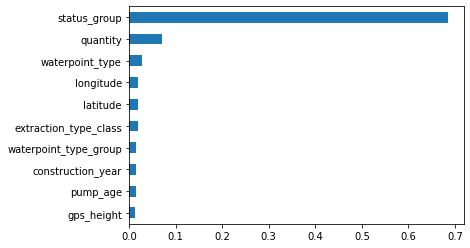

In [ ]:
importances = model.named_steps.randomforestclassifier.feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh');

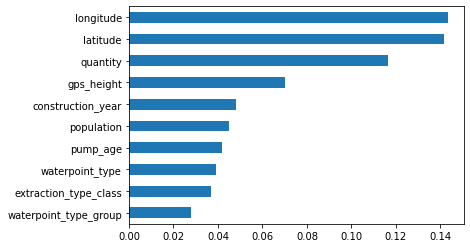

In [ ]:
importances = model.named_steps.randomforestclassifier.feature_importances_
features = X_train.columns
pd.Series(importances, index=features).sort_values().tail(10).plot(kind='barh');

# Check Metrics

**Accuracy Score**

In [ ]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 1.0
Validation Accuracy: 0.9996843434343434


In [ ]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.993870840457714
Validation Accuracy: 0.8067129629629629


In [ ]:
# total 10000 emails
# class 0 - 9900 not spam
# class 1 -100 spam
100/10000

9900/10000

0.99

**Confusion Matrix**

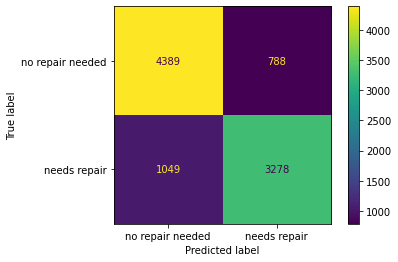

In [ ]:
plot_confusion_matrix(
    model,
    X_val,
    y_val,
    values_format = '.0f',
    display_labels = ['no repair needed', 'needs repair']
    
)

**Precision Score**

Of all the pumps predicted as needing repair, what proportion actually needed repair?

In [ ]:
# precision  = tp/(tp+fp)
3278/3278 + 788

789.0

**Recall Score** 

Of those pumps that actually needed repair, what proportion correctly predict as needing repair?

In [ ]:
# recall = tp/(tp+fn)
3278/3278+1049

1050.0

**Classification Report**

In [ ]:
print(classification_report(y_val,
                      model.predict(X_val),
                      target_names =['no repair needed','needs repair']))

                  precision    recall  f1-score   support

no repair needed       0.81      0.85      0.83      5177
    needs repair       0.81      0.76      0.78      4327

        accuracy                           0.81      9504
       macro avg       0.81      0.80      0.80      9504
    weighted avg       0.81      0.81      0.81      9504



In [ ]:
F-score = (precision * recall) / (precision + recall)

SyntaxError: ignored

# Case Study

Let's say that is costs the Tanzanian government $100 to inspect a water pump, and there is only funding for 2000 pump inspections. 

In [ ]:
n_inspections = 2000

Scenario 1: Choose pumps randomly

In [ ]:
y_val.value_counts(normalize=True)

0    0.544718
1    0.455282
Name: needs_repair, dtype: float64

In [ ]:
repair_prob = 0.455282
print('Inspections conducted:', n_inspections)
print('Pumps repaired:', int(repair_prob * n_inspections) )
print('Funds wasted:', int(n_inspections - repair_prob * n_inspections) * 100) 

Inspections conducted: 2000
Pumps repaired: 910
Funds wasted: 108900


Scenario 2: Using our model "out of the box"

In [ ]:
data = {'y_val': y_val,
        'y_pred': model.predict(X_val) }
results = pd.DataFrame(data)

In [ ]:
results

,y_val,y_pred
id,,
8492.0,1,0
16772.0,1,1
19506.0,0,1
40301.0,1,1
61519.0,0,0
...,...,...
48746.0,1,1
28999.0,0,0
41195.0,1,1


In [ ]:
mask = (results['y_pred'] == 1)
sample = results[mask].sample(n_inspections, random_state =42)

In [ ]:
sample

,y_val,y_pred
id,,
11450.0,1,1
52026.0,1,1
10230.0,1,1
69718.0,1,1
3837.0,1,1
...,...,...
28036.0,1,1
1008.0,0,1
34509.0,0,1


In [ ]:
print('Inspections conducted:', n_inspections)
print('Pumps repaired:', sample['y_val'].sum())
print('Funds wasted:', (n_inspections - sample['y_val'].sum())*100 )

Inspections conducted: 2000
Pumps repaired: 1610
Funds wasted: 39000


Scenario 3: We empasize **precision** in our model, and only select pumps that our model is very certain (`>0.85`) need repair.

In [ ]:
data = {'y_val': y_val,
        'y_pred_proba': model.predict_proba(X_val)[:, -1]}
results = pd.DataFrame(data)

In [ ]:
threshold = 0.90

In [ ]:
mask = (results['y_pred_proba'] > threshold)
sample = results[mask].sample(n_inspections, random_state =42)

In [ ]:
print('Inspections conducted:',n_inspections)
print('Pumps repaired:',sample['y_val'].sum() )
print('Funds wasted:', (n_inspections - sample['y_val'].sum())*100)

Inspections conducted: 2000
Pumps repaired: 1929
Funds wasted: 7100
